In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.layers import GRU, Bidirectional, SimpleRNN, LSTM
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Add, GlobalAveragePooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping

# 1. Load data
train_df = pd.read_csv("/content/drive/MyDrive/UNSW-NB15/CSV Files/Training and Testing Sets/UNSW_NB15_training-set.csv")
test_df = pd.read_csv("/content/drive/MyDrive/UNSW-NB15/CSV Files/Training and Testing Sets/UNSW_NB15_testing-set.csv")

# 2. Combine datasets
data = pd.concat([train_df, test_df], ignore_index=True)

# 3. Encode categorical variables
label_encoder = LabelEncoder()
for col in data.select_dtypes(include=['object']).columns:
    data[col] = label_encoder.fit_transform(data[col])

# 4. Normalize features (MinMaxScaler for broad normalization)
scaler = MinMaxScaler()
features_to_scale = data.columns.difference(['label'])
data[features_to_scale] = scaler.fit_transform(data[features_to_scale])

X = data.drop(columns=['label','id','attack_cat'])
y = data['label']

# 6. Standard scale (optional, if you want to standardize again) — or skip
std_scaler = StandardScaler()
X_scaled = std_scaler.fit_transform(X)

X_reshaped = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))

# 8. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y, test_size=0.2, random_state=42
)

print("Training shape:", X_train.shape, y_train.shape)
print("Testing shape: ", X_test.shape, y_test.shape)

Training shape: (206138, 42, 1) (206138,)
Testing shape:  (51535, 42, 1) (51535,)


In [ ]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test, epochs=10, batch_size=32):
    """
    Trains the given compiled model and evaluates performance on test data.
    """
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    )

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )

    # Predictions & metrics
    y_pred = model.predict(X_test)
    y_pred_binary = (y_pred > 0.5).astype(int)

    acc = accuracy_score(y_test, y_pred_binary)
    prec = precision_score(y_test, y_pred_binary)
    rec = recall_score(y_test, y_pred_binary)
    f1 = f1_score(y_test, y_pred_binary)

    print("\nModel Performance:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    return history

In [ ]:
def create_mlp(input_shape):
    """
    A simple MLP architecture.
    input_shape: (timesteps, 1) where timesteps = number of features
                 But effectively we'll Flatten since MLP doesn't need 3D.
    """
    inputs = Input(shape=input_shape)
    x = Flatten()(inputs)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
def create_simple_rnn(input_shape):
    """
    A single directional GRU for sequence modeling.
    """
    inputs = Input(shape=input_shape)
    x = GRU(64)(inputs)
    x = Dropout(0.2)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
def create_cnn(input_shape):
    """
    Simple 1D CNN architecture.
    """
    inputs = Input(shape=input_shape)
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.2)(x)

    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
def create_cnn_gru(input_shape):
    """
    CNN -> GRU -> Dense
    """
    inputs = Input(shape=input_shape)

    # CNN Block
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.2)(x)

    # GRU
    x = GRU(64, return_sequences=False)(x)
    x = Dropout(0.2)(x)

    # Dense
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
def create_cnn_bigru(input_shape):
    """
    CNN -> Bidirectional GRU -> Dense
    """
    inputs = Input(shape=input_shape)

    # CNN
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.2)(x)

    # BiGRU
    x = Bidirectional(GRU(64, return_sequences=False))(x)
    x = Dropout(0.2)(x)

    # Dense
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
def create_cnn_bigru_attention(input_shape):
    """
    CNN -> BiGRU (return seq) -> Multi-Head Attention -> Residual + LayerNorm
      -> GlobalAveragePooling -> Dense -> Output
    """
    inputs = Input(shape=input_shape)

    # CNN
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.2)(x)

    # BiGRU, we need return_sequences=True for attention
    x = Bidirectional(GRU(50, return_sequences=True))(x)

    # Multi-Head Attention (Self-Attention)
    attention_output = MultiHeadAttention(num_heads=4, key_dim=50)(x, x)
    # Residual connection
    attention_output = Add()([x, attention_output])
    # Layer Normalization
    attention_output = LayerNormalization()(attention_output)

    # Global pooling to collapse the time dimension
    x = GlobalAveragePooling1D()(attention_output)

    # Dense
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.2)(x)

    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
def create_cnn_lstm(input_shape):
    """
    CNN -> LSTM (uni-directional) -> Dense -> Output
    """
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import (
        Input, Conv1D, MaxPooling1D, Dropout, LSTM,
        Dense, Flatten
    )

    inputs = Input(shape=input_shape)

    # CNN block
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.2)(x)

    # Unidirectional LSTM
    x = LSTM(64, return_sequences=False)(x)
    x = Dropout(0.2)(x)

    # Dense
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
def create_cnn_bilstm(input_shape):
    """
    CNN -> BiLSTM -> Dense -> Output
    """
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import (
        Input, Conv1D, MaxPooling1D, Dropout, LSTM, Bidirectional,
        Dense, Flatten
    )

    inputs = Input(shape=input_shape)

    # CNN block
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.2)(x)

    # Bidirectional LSTM
    x = Bidirectional(LSTM(64, return_sequences=False))(x)
    x = Dropout(0.2)(x)

    # Dense
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
def create_cnn_bilstm_attention(input_shape):
    """
    CNN -> BiLSTM (return seq) -> Multi-Head Attention -> Residual + LayerNorm
      -> GlobalAveragePooling -> Dense -> Output
    """
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import (
        Input, Conv1D, MaxPooling1D, Dropout,
        LSTM, Bidirectional, MultiHeadAttention,
        LayerNormalization, Add, GlobalAveragePooling1D,
        Dense
    )

    inputs = Input(shape=input_shape)

    # CNN block
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.2)(x)

    # BiLSTM, note: return_sequences=True for attention
    x = Bidirectional(LSTM(50, return_sequences=True))(x)

    # Multi-Head Attention (Self-Attention)
    attention_output = MultiHeadAttention(num_heads=4, key_dim=50)(x, x)

    # Residual connection
    attention_output = Add()([x, attention_output])
    # Layer Normalization
    attention_output = LayerNormalization()(attention_output)

    # Global Pooling
    x = GlobalAveragePooling1D()(attention_output)

    # Fully connected for classification
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.2)(x)

    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
# 1. MLP baseline
model_mlp = create_mlp((X_train.shape[1], X_train.shape[2]))
history_mlp = train_and_evaluate(model_mlp, X_train, y_train, X_test, y_test)

Epoch 1/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.8926 - loss: 0.2286 - val_accuracy: 0.9360 - val_loss: 0.1368
Epoch 2/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9325 - loss: 0.1444 - val_accuracy: 0.9449 - val_loss: 0.1240
Epoch 3/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9404 - loss: 0.1293 - val_accuracy: 0.9463 - val_loss: 0.1200
Epoch 4/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9429 - loss: 0.1257 - val_accuracy: 0.9485 - val_loss: 0.1140
Epoch 5/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.9449 - loss: 0.1204 - val_accuracy: 0.9506 - val_loss: 0.1084
Epoch 6/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9473 - loss: 0.1164 - val_accuracy: 0.9519 - val_loss: 0.1038
Epoch 7/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9507 - loss: 0.1105 - val_accuracy: 0.9583 - val_loss: 0.0963
Epoch 8/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9527 - loss: 0

In [ ]:
model_mlp.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 25, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,333 (44.27 KB)

 Trainable params: 3,777 (14.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,556 (29.52 KB)

In [ ]:
# 2. Simple RNN baseline
model_rnn = create_simple_rnn((X_train.shape[1], X_train.shape[2]))
history_rnn = train_and_evaluate(model_rnn, X_train, y_train, X_test, y_test)

Epoch 1/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.8650 - loss: 0.2821 - val_accuracy: 0.9377 - val_loss: 0.1516
Epoch 2/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.9380 - loss: 0.1491 - val_accuracy: 0.9456 - val_loss: 0.1311
Epoch 3/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - accuracy: 0.9492 - loss: 0.1216 - val_accuracy: 0.9601 - val_loss: 0.0975
Epoch 4/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - accuracy: 0.9568 - loss: 0.1043 - val_accuracy: 0.9599 - val_loss: 0.0977
Epoch 5/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - accuracy: 0.9604 - loss: 0.0957 - val_accuracy: 0.9609 - val_loss: 0.0960
Epoch 6/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - accuracy: 0.9627 - loss: 0.0909 - val_accuracy: 0.9653 - val_loss: 0.0876
Epoch 7/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - accuracy: 0.9642 - loss: 0.0865 - val_accuracy: 0.9642 - val_loss: 0.0877
Epoch 8/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - accuracy: 0.9646 - loss: 0

In [ ]:
model_rnn.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 25, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 64)                  │          12,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,789 (151.52 KB)

 Trainable params: 12,929 (50.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 25,860 (101.02 KB)

In [ ]:
# 3. CNN only
model_cnn = create_cnn((X_train.shape[1], X_train.shape[2]))
history_cnn = train_and_evaluate(model_cnn, X_train, y_train, X_test, y_test)

Epoch 1/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.8996 - loss: 0.2065 - val_accuracy: 0.9398 - val_loss: 0.1313
Epoch 2/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.9344 - loss: 0.1413 - val_accuracy: 0.9452 - val_loss: 0.1236
Epoch 3/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9407 - loss: 0.1314 - val_accuracy: 0.9490 - val_loss: 0.1156
Epoch 4/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9428 - loss: 0.1250 - val_accuracy: 0.9524 - val_loss: 0.1110
Epoch 5/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9477 - loss: 0.1171 - val_accuracy: 0.9589 - val_loss: 0.1005
Epoch 6/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9510 - loss: 0.1126 - val_accuracy: 0.9606 - val_loss: 0.0964
Epoch 7/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9538 - loss: 0.1068 - val_accuracy: 0.9649 - val_loss: 0.0896
Epoch 8/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9560 - loss: 0

In [ ]:
model_cnn.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 25, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 23, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 11, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 11, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 704)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │          45,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 136,325 (532.52 KB)

 Trainable params: 45,441 (177.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 90,884 (355.02 KB)

In [ ]:
# 4. CNN + GRU
model_cnn_gru = create_cnn_gru((X_train.shape[1], X_train.shape[2]))
history_cnn_gru = train_and_evaluate(model_cnn_gru, X_train, y_train, X_test, y_test)

Epoch 1/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 35s 6ms/step - accuracy: 0.8811 - loss: 0.2532 - val_accuracy: 0.9362 - val_loss: 0.1367
Epoch 2/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 34s 7ms/step - accuracy: 0.9333 - loss: 0.1436 - val_accuracy: 0.9433 - val_loss: 0.1300
Epoch 3/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - accuracy: 0.9381 - loss: 0.1323 - val_accuracy: 0.9464 - val_loss: 0.1160
Epoch 4/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - accuracy: 0.9451 - loss: 0.1202 - val_accuracy: 0.9608 - val_loss: 0.0935
Epoch 5/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - accuracy: 0.9552 - loss: 0.1035 - val_accuracy: 0.9649 - val_loss: 0.0845
Epoch 6/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - accuracy: 0.9601 - loss: 0.0942 - val_accuracy: 0.9662 - val_loss: 0.0805
Epoch 7/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 45s 8ms/step - accuracy: 0.9613 - loss: 0.0913 - val_accuracy: 0.9681 - val_loss: 0.0786
Epoch 8/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 81s 8ms/step - accuracy: 0.9627 - loss: 0

In [ ]:
model_cnn_gru.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 25, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 23, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 11, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 11, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 64)                  │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 88,325 (345.02 KB)

 Trainable params: 29,441 (115.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 58,884 (230.02 KB)

In [ ]:
# 5. CNN + LSTM
model_lstm_uni = create_cnn_lstm((X_train.shape[1], X_train.shape[2]))
history_lstm_uni = train_and_evaluate(model_lstm_uni, X_train, y_train, X_test, y_test, epochs=10, batch_size=32)

Epoch 1/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 35s 6ms/step - accuracy: 0.8649 - loss: 0.2740 - val_accuracy: 0.9226 - val_loss: 0.1579
Epoch 2/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 44s 7ms/step - accuracy: 0.9229 - loss: 0.1562 - val_accuracy: 0.9415 - val_loss: 0.1276
Epoch 3/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - accuracy: 0.9364 - loss: 0.1372 - val_accuracy: 0.9451 - val_loss: 0.1185
Epoch 4/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - accuracy: 0.9399 - loss: 0.1284 - val_accuracy: 0.9467 - val_loss: 0.1175
Epoch 5/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - accuracy: 0.9458 - loss: 0.1195 - val_accuracy: 0.9567 - val_loss: 0.0965
Epoch 6/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - accuracy: 0.9551 - loss: 0.1025 - val_accuracy: 0.9642 - val_loss: 0.0838
Epoch 7/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - accuracy: 0.9590 - loss: 0.0961 - val_accuracy: 0.9642 - val_loss: 0.0820
Epoch 8/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 36s 7ms/step - accuracy: 0.9621 - loss: 0

In [ ]:
model_lstm_uni.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 25, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 23, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 11, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 11, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 112,517 (439.52 KB)

 Trainable params: 37,505 (146.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 75,012 (293.02 KB)

In [ ]:
# 6. CNN + BiGRU
model_cnn_bigru = create_cnn_bigru((X_train.shape[1], X_train.shape[2]))
history_cnn_bigru = train_and_evaluate(model_cnn_bigru, X_train, y_train, X_test, y_test)

Epoch 1/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 44s 8ms/step - accuracy: 0.8895 - loss: 0.2321 - val_accuracy: 0.9364 - val_loss: 0.1334
Epoch 2/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - accuracy: 0.9380 - loss: 0.1352 - val_accuracy: 0.9552 - val_loss: 0.1049
Epoch 3/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - accuracy: 0.9518 - loss: 0.1126 - val_accuracy: 0.9575 - val_loss: 0.0973
Epoch 4/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - accuracy: 0.9574 - loss: 0.0995 - val_accuracy: 0.9641 - val_loss: 0.0846
Epoch 5/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 43s 8ms/step - accuracy: 0.9601 - loss: 0.0950 - val_accuracy: 0.9661 - val_loss: 0.0820
Epoch 6/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step - accuracy: 0.9612 - loss: 0.0907 - val_accuracy: 0.9702 - val_loss: 0.0743
Epoch 7/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 83s 8ms/step - accuracy: 0.9633 - loss: 0.0870 - val_accuracy: 0.9691 - val_loss: 0.0735
Epoch 8/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step - accuracy: 0.9654 - loss: 0

In [ ]:
model_cnn_bigru.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 25, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 23, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 11, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 11, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │          49,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 175,493 (685.52 KB)

 Trainable params: 58,497 (228.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 116,996 (457.02 KB)

In [ ]:
# 7. CNN + BiLSTM
model_lstm_bi = create_cnn_bilstm((X_train.shape[1], X_train.shape[2]))
history_lstm_bi = train_and_evaluate(model_lstm_bi, X_train, y_train, X_test, y_test, epochs=10, batch_size=32)

Epoch 1/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 94s 17ms/step - accuracy: 0.8806 - loss: 0.2687 - val_accuracy: 0.9167 - val_loss: 0.1758
Epoch 2/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 88s 17ms/step - accuracy: 0.9155 - loss: 0.1816 - val_accuracy: 0.9226 - val_loss: 0.1679
Epoch 3/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 143s 17ms/step - accuracy: 0.9198 - loss: 0.1743 - val_accuracy: 0.9242 - val_loss: 0.1634
Epoch 4/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 89s 17ms/step - accuracy: 0.9211 - loss: 0.1715 - val_accuracy: 0.9233 - val_loss: 0.1676
Epoch 5/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 145s 18ms/step - accuracy: 0.9227 - loss: 0.1693 - val_accuracy: 0.9263 - val_loss: 0.1579
Epoch 6/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 141s 18ms/step - accuracy: 0.9253 - loss: 0.1636 - val_accuracy: 0.9294 - val_loss: 0.1593
Epoch 7/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 144s 18ms/step - accuracy: 0.9292 - loss: 0.1597 - val_accuracy: 0.9313 - val_loss: 0.1526
Epoch 8/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 138s 17ms/step - accuracy: 0.9

In [ ]:
model_lstm_bi.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 25, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 23, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 11, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 11, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 128)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 223,877 (874.52 KB)

 Trainable params: 74,625 (291.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 149,252 (583.02 KB)

In [ ]:
# 8. CNN + BiGRU + Attention
model_cnn_bigru_attn = create_cnn_bigru_attention((X_train.shape[1], X_train.shape[2]))
history_cnn_bigru_attn = train_and_evaluate(model_cnn_bigru_attn, X_train, y_train, X_test, y_test)

Epoch 1/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 63s 11ms/step - accuracy: 0.8792 - loss: 0.2594 - val_accuracy: 0.9194 - val_loss: 0.1601
Epoch 2/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 57s 11ms/step - accuracy: 0.9258 - loss: 0.1546 - val_accuracy: 0.9435 - val_loss: 0.1270
Epoch 3/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 84s 11ms/step - accuracy: 0.9400 - loss: 0.1314 - val_accuracy: 0.9526 - val_loss: 0.1111
Epoch 4/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 80s 11ms/step - accuracy: 0.9508 - loss: 0.1126 - val_accuracy: 0.9592 - val_loss: 0.0962
Epoch 5/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - accuracy: 0.9577 - loss: 0.1006 - val_accuracy: 0.9624 - val_loss: 0.0866
Epoch 6/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 57s 11ms/step - accuracy: 0.9582 - loss: 0.0964 - val_accuracy: 0.9656 - val_loss: 0.0826
Epoch 7/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - accuracy: 0.9606 - loss: 0.0909 - val_accuracy: 0.9679 - val_loss: 0.0770
Epoch 8/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - accuracy: 0.9622 -

In [ ]:
model_cnn_bigru_attn.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 25, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_5 (Conv1D)         │ (None, 23, 64)         │            256 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_5           │ (None, 11, 64)         │              0 │ conv1d_5[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_17 (Dropout)      │ (None, 11, 64)         │              0 │ max_pooling1d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, 11, 100)        │         34,800 │ dropout_17[0][0]       │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 11, 100)        │         80,700 │ bidirectional_2[0][0], │
│ (MultiHeadAttention)      │                        │                │ bidirectional_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 11, 100)        │              0 │ bidirectional_2[0][0], │
│                           │                        │                │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 11, 100)        │            200 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 100)            │              0 │ layer_normalization[0… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 100)            │         10,100 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_19 (Dropout)      │ (None, 100)            │              0 │ dense_14[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 1)              │            101 │ dropout_19[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 378,473 (1.44 MB)

 Trainable params: 126,157 (492.80 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 252,316 (985.61 KB)

In [ ]:
# 9. CNN + BiLSTM + Attention
model_lstm_bi_attn = create_cnn_bilstm_attention((X_train.shape[1], X_train.shape[2]))
history_lstm_bi_attn = train_and_evaluate(model_lstm_bi_attn, X_train, y_train, X_test, y_test, epochs=10, batch_size=32)

Epoch 1/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 64s 11ms/step - accuracy: 0.8747 - loss: 0.2630 - val_accuracy: 0.9075 - val_loss: 0.1694
Epoch 2/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 84s 12ms/step - accuracy: 0.9290 - loss: 0.1553 - val_accuracy: 0.9502 - val_loss: 0.1204
Epoch 3/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 80s 11ms/step - accuracy: 0.9428 - loss: 0.1303 - val_accuracy: 0.9574 - val_loss: 0.1014
Epoch 4/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 59s 11ms/step - accuracy: 0.9521 - loss: 0.1121 - val_accuracy: 0.9614 - val_loss: 0.0901
Epoch 5/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 84s 12ms/step - accuracy: 0.9565 - loss: 0.1031 - val_accuracy: 0.9635 - val_loss: 0.0865
Epoch 6/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 81s 12ms/step - accuracy: 0.9584 - loss: 0.0989 - val_accuracy: 0.9627 - val_loss: 0.0866
Epoch 7/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 88s 13ms/step - accuracy: 0.9585 - loss: 0.0961 - val_accuracy: 0.9643 - val_loss: 0.0846
Epoch 8/10
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 79s 12ms/step - accuracy: 0.9605 -

In [ ]:
model_lstm_bi_attn.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 25, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_6 (Conv1D)         │ (None, 23, 64)         │            256 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_6           │ (None, 11, 64)         │              0 │ conv1d_6[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_20 (Dropout)      │ (None, 11, 64)         │              0 │ max_pooling1d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_3           │ (None, 11, 100)        │         46,000 │ dropout_20[0][0]       │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 11, 100)        │         80,700 │ bidirectional_3[0][0], │
│ (MultiHeadAttention)      │                        │                │ bidirectional_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 11, 100)        │              0 │ bidirectional_3[0][0], │
│                           │                        │                │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 11, 100)        │            200 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 100)            │              0 │ layer_normalization_1… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_16 (Dense)          │ (None, 100)            │         10,100 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_22 (Dropout)      │ (None, 100)            │              0 │ dense_16[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_17 (Dense)          │ (None, 1)              │            101 │ dropout_22[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 412,073 (1.57 MB)

 Trainable params: 137,357 (536.55 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 274,716 (1.05 MB)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def plot_training_and_confusion_matrix(history, model, X_test, y_test, class_names=('Normal', 'Attack')):
    """
    Plots the training/validation accuracy and loss from `history`,
    computes and displays the confusion matrix for predictions on X_test,
    and prints Accuracy, Precision, Recall, and F1-score.

    Parameters:
    -----------
    history : tf.keras.callbacks.History
        The training history object returned by `model.fit(...)`.
    model : tf.keras.Model
        The trained model used to predict on X_test.
    X_test : np.ndarray
        Test feature set.
    y_test : np.ndarray or pd.Series
        True labels for the test set.
    class_names : tuple or list
        Class labels for the confusion matrix axes.
    """

    # 1. Predictions
    y_pred = model.predict(X_test)
    y_pred_binary = (y_pred > 0.5).astype(int)

    # 2. Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred_binary)

    # 3. Plot accuracy and loss
    plt.figure(figsize=(18, 5))

    # -- Subplot 1: Accuracy
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # -- Subplot 2: Loss
    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # -- Subplot 3: Confusion Matrix
    plt.subplot(1, 3, 3)
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = range(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment='center',
                     color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # Show the combined plot
    plt.show()

    # 4. Print metrics
    acc = accuracy_score(y_test, y_pred_binary)
    prec = precision_score(y_test, y_pred_binary)
    rec = recall_score(y_test, y_pred_binary)
    f1 = f1_score(y_test, y_pred_binary)

    print("Evaluation Metrics:")
    print(f"Accuracy :  {acc:.4f}")
    print(f"Precision:  {prec:.4f}")
    print(f"Recall   :  {rec:.4f}")
    print(f"F1 Score :  {f1:.4f}")

1611/1611 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


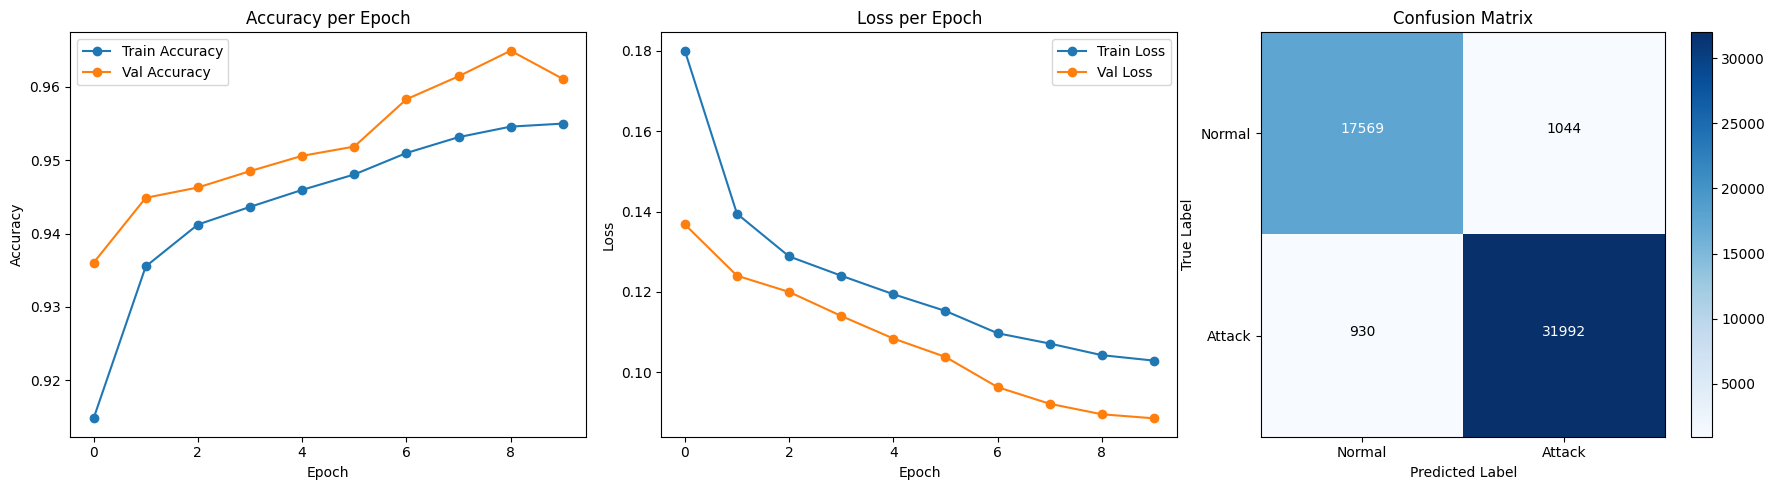

Evaluation Metrics:
Accuracy :  0.9617
Precision:  0.9684
Recall   :  0.9718
F1 Score :  0.9701


In [ ]:
#MLP
plot_training_and_confusion_matrix(
    history=history_mlp,
    model=model_mlp,
    X_test=X_test,
    y_test=y_test,
    class_names=['Normal', 'Attack']
)

1611/1611 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


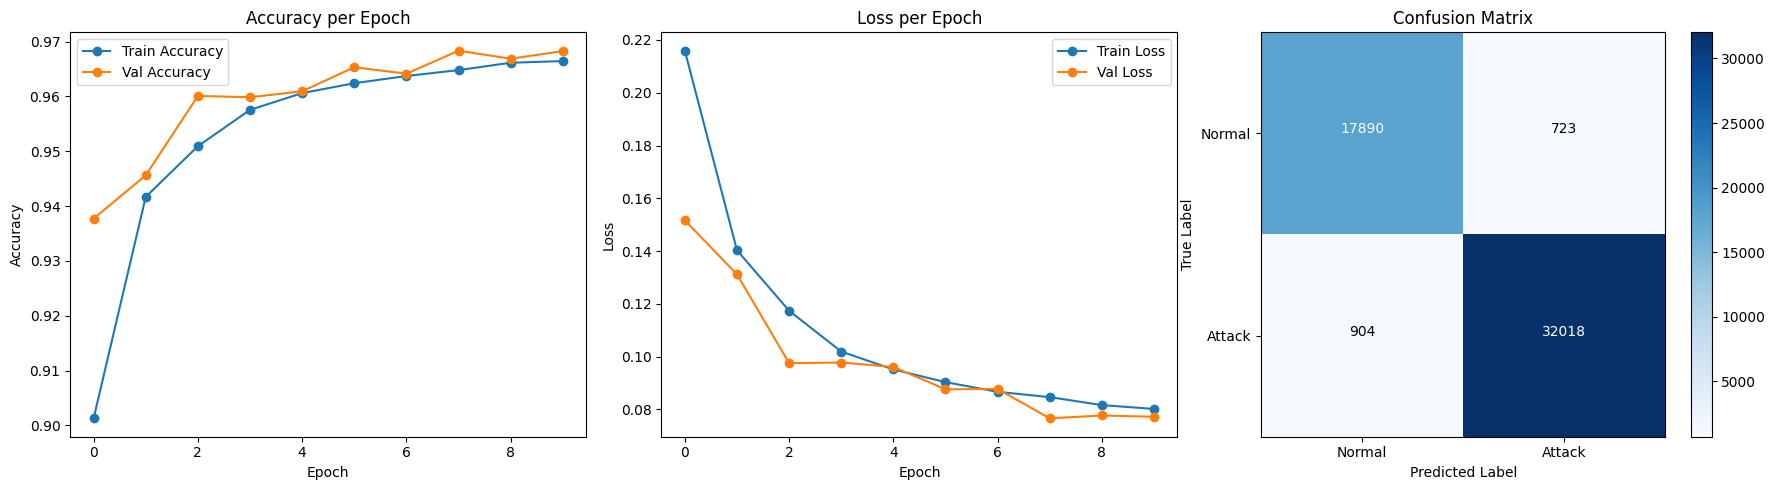

Evaluation Metrics:
Accuracy :  0.9684
Precision:  0.9779
Recall   :  0.9725
F1 Score :  0.9752


In [ ]:
#Simple RNN (GRU)
plot_training_and_confusion_matrix(
    history=history_rnn,
    model=model_rnn,
    X_test=X_test,
    y_test=y_test,
    class_names=['Normal', 'Attack']
)

1611/1611 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


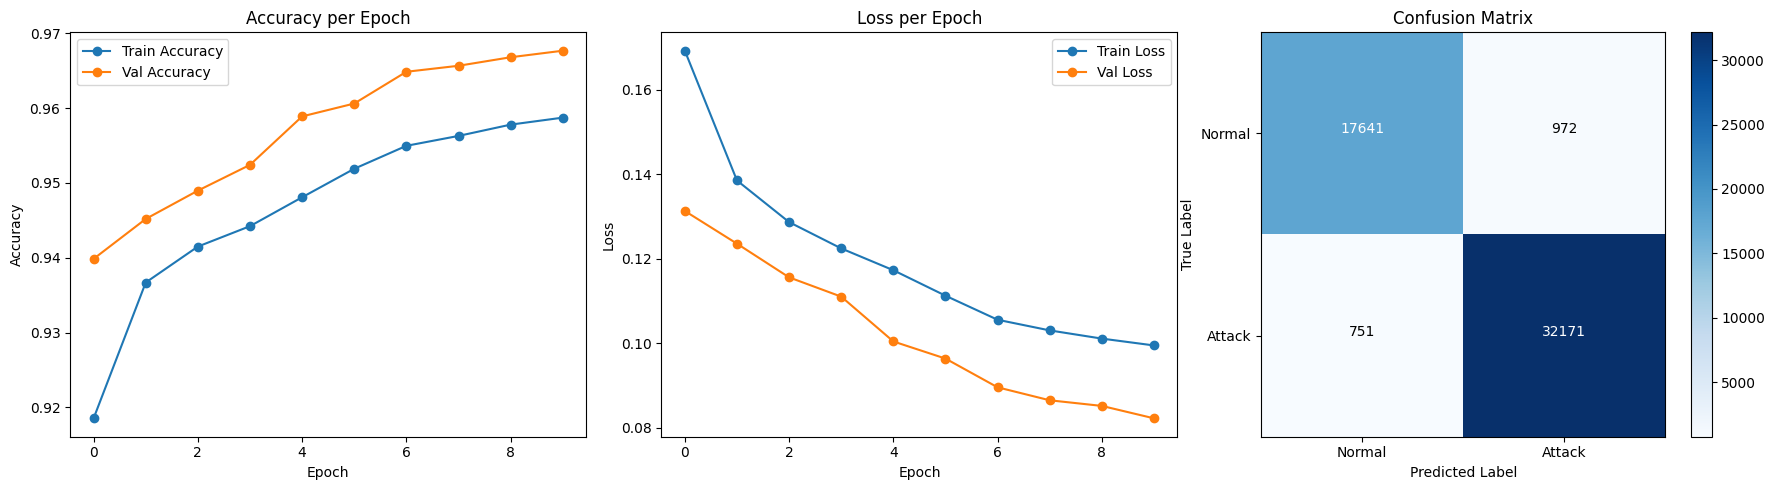

Evaluation Metrics:
Accuracy :  0.9666
Precision:  0.9707
Recall   :  0.9772
F1 Score :  0.9739


In [ ]:
#CNN
plot_training_and_confusion_matrix(
    history=history_cnn,
    model=model_cnn,
    X_test=X_test,
    y_test=y_test,
    class_names=['Normal', 'Attack']
)

1611/1611 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


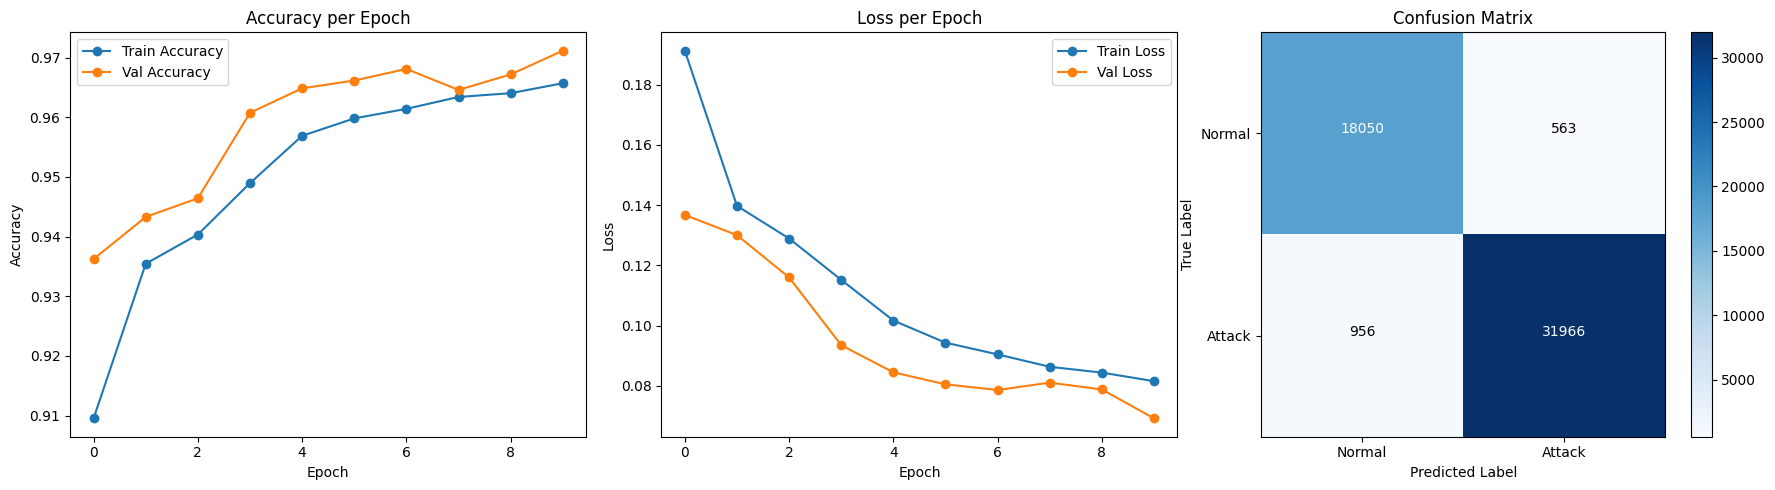

Evaluation Metrics:
Accuracy :  0.9705
Precision:  0.9827
Recall   :  0.9710
F1 Score :  0.9768


In [ ]:
#CNN + GRU
plot_training_and_confusion_matrix(
    history=history_cnn_gru,
    model=model_cnn_gru,
    X_test=X_test,
    y_test=y_test,
    class_names=['Normal', 'Attack']
)

1611/1611 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


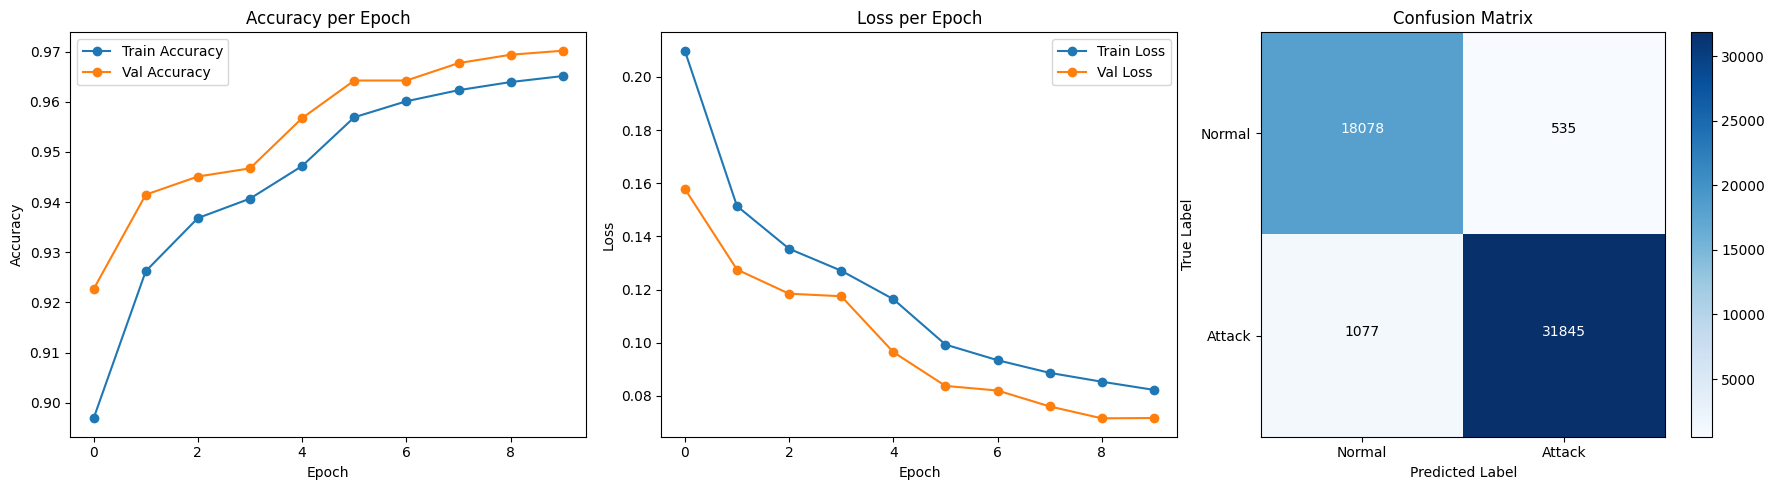

Evaluation Metrics:
Accuracy :  0.9687
Precision:  0.9835
Recall   :  0.9673
F1 Score :  0.9753


In [ ]:
#CNN + LSTM
plot_training_and_confusion_matrix(
    history=history_lstm_uni,
    model=model_lstm_uni,
    X_test=X_test,
    y_test=y_test,
    class_names=['Normal', 'Attack']
)

1611/1611 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


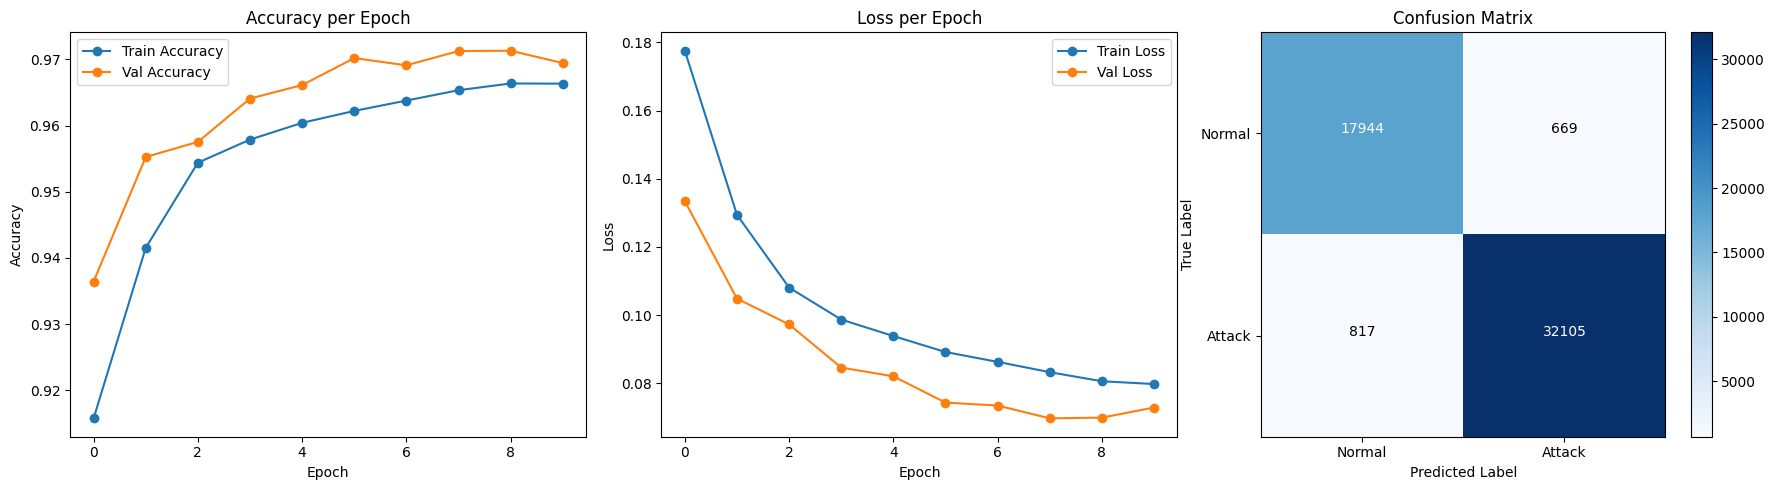

Evaluation Metrics:
Accuracy :  0.9712
Precision:  0.9796
Recall   :  0.9752
F1 Score :  0.9774


In [ ]:
#########################################################
#CNN + BiGRU
plot_training_and_confusion_matrix(
    history=history_cnn_bigru,
    model=model_cnn_bigru,
    X_test=X_test,
    y_test=y_test,
    class_names=['Normal', 'Attack']
)

1611/1611 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step


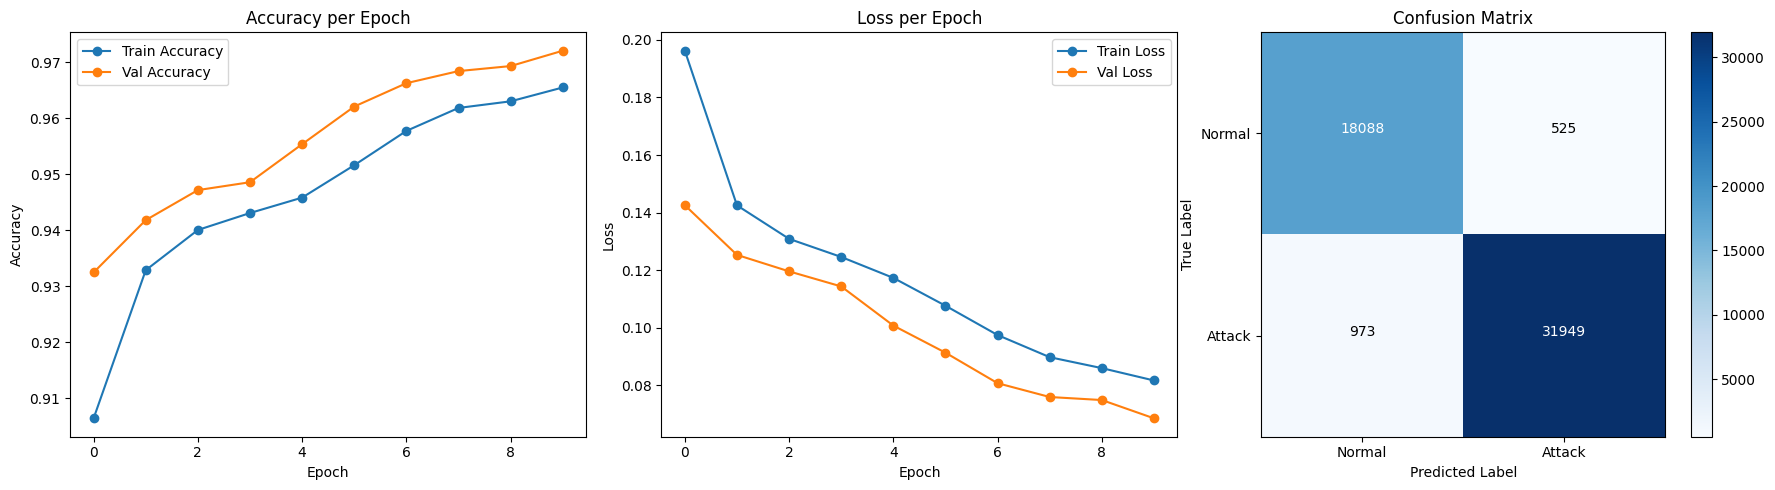

Evaluation Metrics:
Accuracy :  0.9709
Precision:  0.9838
Recall   :  0.9704
F1 Score :  0.9771


In [ ]:
#CNN + BiLSTM
plot_training_and_confusion_matrix(
    history=history_lstm_bi,
    model=model_lstm_bi,
    X_test=X_test,
    y_test=y_test,
    class_names=['Normal', 'Attack']
)

1611/1611 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step


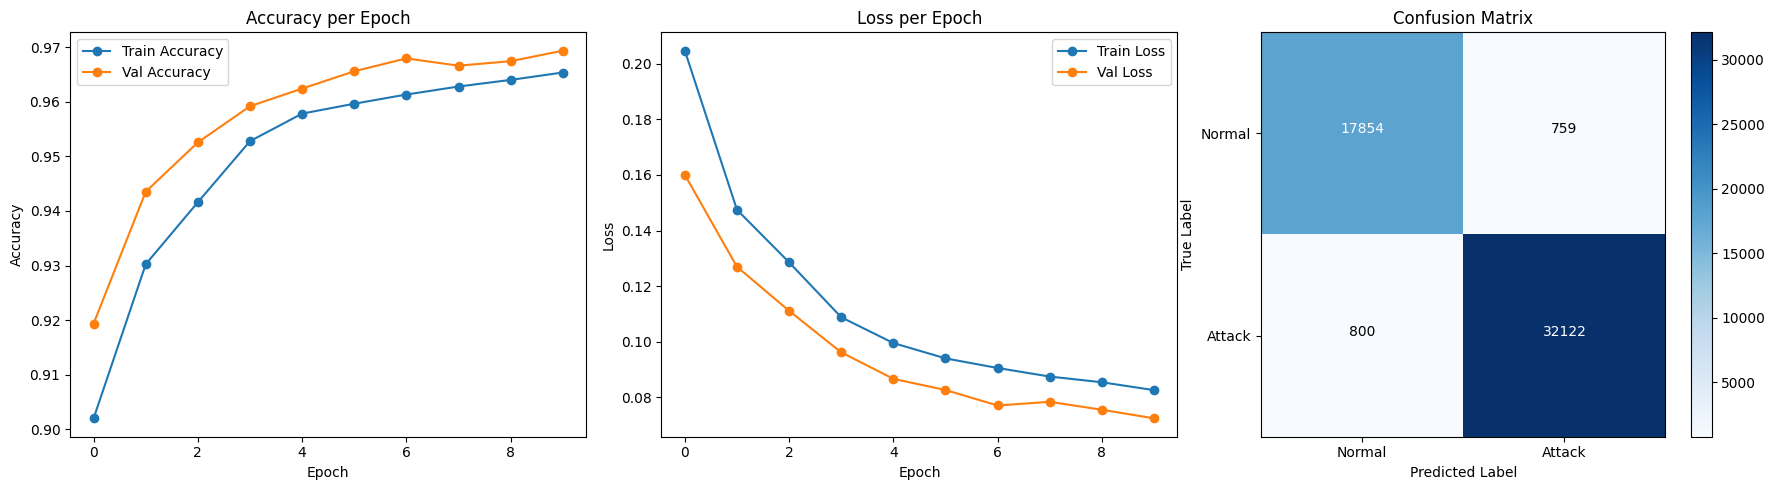

Evaluation Metrics:
Accuracy :  0.9697
Precision:  0.9769
Recall   :  0.9757
F1 Score :  0.9763


In [ ]:
#CNN + BiGRU + Attention
plot_training_and_confusion_matrix(
    history=history_cnn_bigru_attn,
    model=model_cnn_bigru_attn,
    X_test=X_test,
    y_test=y_test,
    class_names=['Normal', 'Attack']
)

1611/1611 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


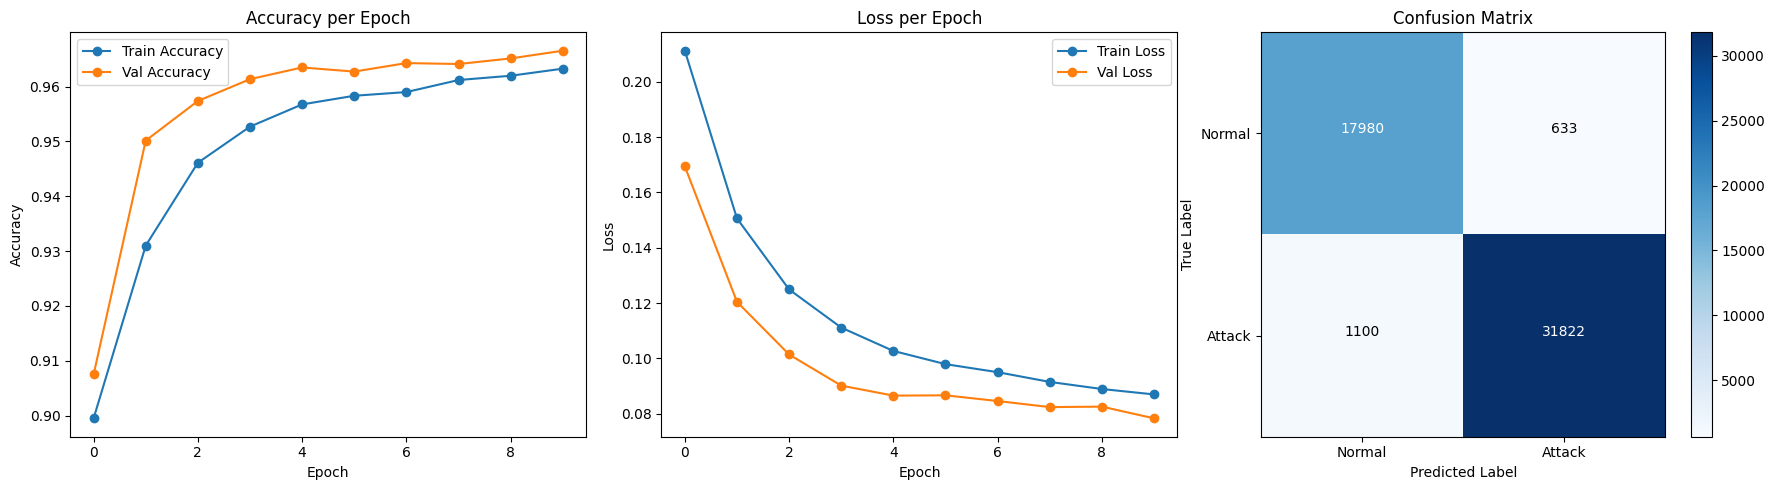

Evaluation Metrics:
Accuracy :  0.9664
Precision:  0.9805
Recall   :  0.9666
F1 Score :  0.9735


In [ ]:
#CNN + BiLSTM + Attention
plot_training_and_confusion_matrix(
    history=history_lstm_bi_attn,
    model=model_lstm_bi_attn,
    X_test=X_test,
    y_test=y_test,
    class_names=['Normal', 'Attack']
)